# Regression Logistique: Risque cardio-vasculaire
___

# Visualisation, preprocessing et analyse des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
sns.set_theme()

In [2]:
df_original = pd.read_csv("data/cardio_train.csv", sep=";")
df_original.head()
df_original.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
df_original["age"] = df_original["age"]/365

In [4]:
global_scaler = MinMaxScaler().fit(df_original)
df = pd.DataFrame(global_scaler.transform(df_original), columns = df_original.columns)

df_custom = df_original.drop(["id", "gender", "cardio", "alco"], axis=1)
custom_scaler = MinMaxScaler().fit(df_custom)
df_custom = pd.DataFrame(custom_scaler.transform(df_custom), columns=df_custom.columns)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.00000,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00001,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0,1.0
2,0.00002,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0,1.0
3,0.00003,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0,1.0
4,0.00004,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0,0.0


### Corrélations entre les différentes colonnes du DataSet

In [5]:
corr = df.corr().iloc[1:, 1:]

<AxesSubplot:>

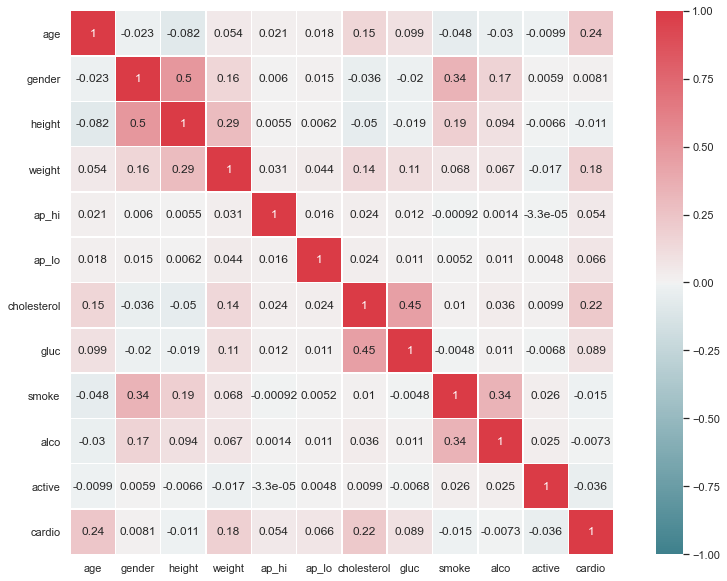

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(210, 10, as_cmap=True), annot=True, linewidths=.5, square=True, ax=ax)

### Analyse des facteurs principaux liés aux risques cardio-vasculaires

In [7]:
idx = [("cardio", "age"), ("cardio", "weight"), ("cardio", "cholesterol"), ("cardio", "gluc"), ("cardio", "ap_lo")]

c = corr.abs()
s = c.unstack()
so = s.sort_values(ascending=False).to_frame().rename(columns={0:"Coefficient de corrélation"})
so[so.index.isin(idx)]

Coefficient de corrélation
cardio age                            0.238159
       cholesterol                    0.221147
       weight                         0.181660
       gluc                           0.089307
       ap_lo                          0.065719

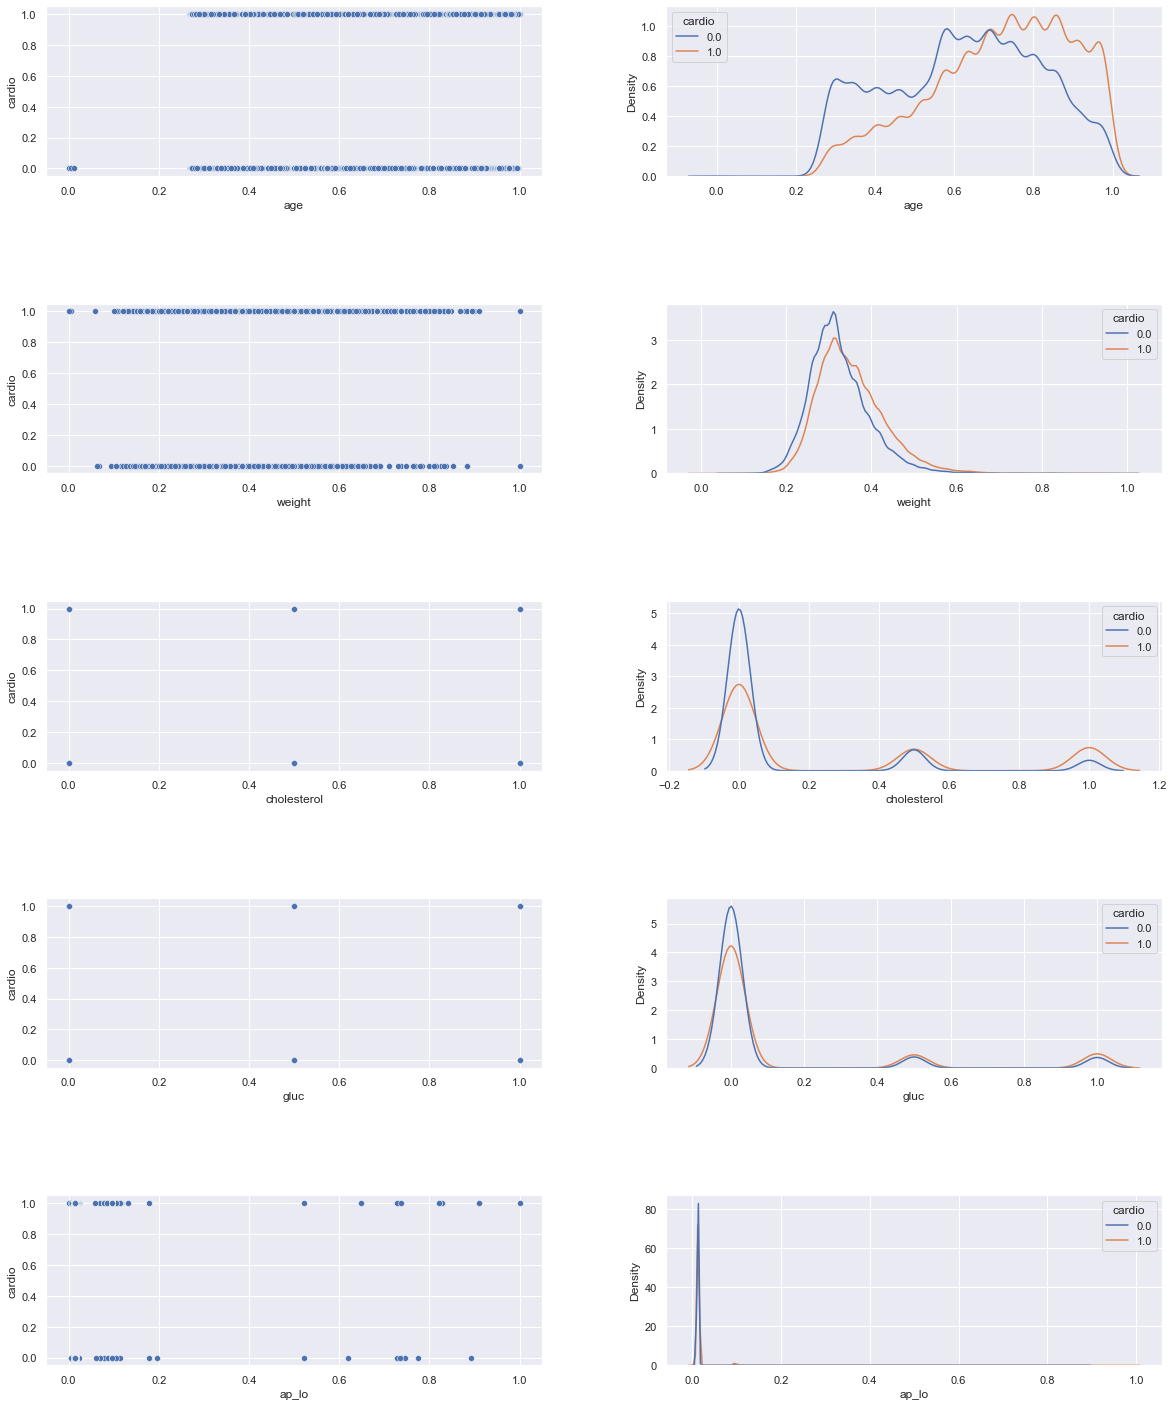

In [8]:
f, axs = plt.subplots(5, 2, figsize=(20, 25), facecolor='w', edgecolor='k')

for row in range(len(axs)):
    hue = df[idx[row][0]]
    x = df[idx[row][1]]
    
    sns.scatterplot(x=x, y=hue, ax=axs[row][0])
    sns.kdeplot(x=x, hue=hue, ax=axs[row][1])

    plt.subplots_adjust(hspace=.75, wspace=.25)

## 5 indicateurs principaux : age, choléstérol, poids, taux de glucose dans le sang, pression sanguine
___

# Implémentation de la regression logistique sous SKLearn via SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
features = df[["gluc", "cholesterol", "weight", "age", "ap_lo", "ap_hi"]]
label = df["cardio"]

In [11]:
learning_rate = 0.1
iterations = 750

### Set de test via SKLearn

In [12]:
train_features, test_features, train_label, test_label = train_test_split(features, label, test_size=0.2, shuffle=True)

### Déclaration et entrainement du modèle

In [13]:
%%capture
model = SGDClassifier(max_iter=iterations, eta0=learning_rate, loss="log")
model.fit(train_features, train_label)

### Test du modèle sur les données de test

In [14]:
pred = model.predict(test_features)

### Analyse des résultats

In [15]:
accuracy = round(accuracy_score(test_label, pred)*100, 2)
f"Précision du modèle évalué à : {accuracy} %"

'Précision du modèle évalué à : 64.04 %'

#### Matrice de confusion: permet d'analyser le nombre de cas où le modèle présente/(ne présente pas) un résultat fiable sur sa target et églament de de savoir si il s'est trompé négativement ou positivement. (True Positive/Negative; False Positive/Negative)


<AxesSubplot:>

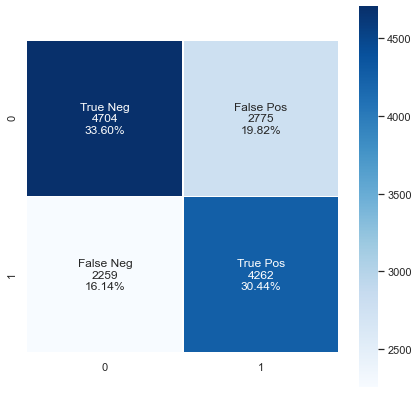

In [16]:
fig10, ax10 = plt.subplots(figsize=(7, 7))
conf_matrix = confusion_matrix(pred, test_label)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', linewidths=.5, square=True, ax=ax10)

___
# Implémentation de la régression logistique perso.

In [17]:
from Classifier import LogisticRegression

### Déclaration en entrainement du modèle

In [18]:
model2 = LogisticRegression(train_features.to_numpy(), train_label.to_numpy())

cost_history = model2.gradient_descent(iterations, learning_rate)

### Test du modèle sur les données de test

In [19]:
pred2 = model2.predict(test_features)

### Affichage des résultats

In [20]:
accuracy2 = round(accuracy_score(test_label, pred2) * 100, 2)
f"Précision du modèle évalué à : {accuracy2} %"

'Précision du modèle évalué à : 58.68 %'

In [21]:
# Évolution de la Fonction de cout
def myplot(hist):
    fig5, ax5 = plt.subplots(figsize=(5, 5))
    ax5.xaxis.set_ticks(np.arange(0, 2000, 100))
    plt.suptitle('Diminution de la fonction de cout', fontsize=20)
    plt.xlabel("n", fontsize=14)
    plt.ylabel("Fonction de cout", fontsize=14)
    plt.plot(range(iterations), hist)
    plt.show()

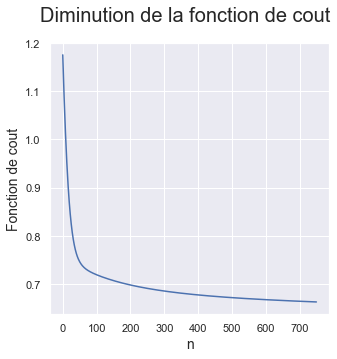

In [22]:
myplot(cost_history)

### Avec les 5 features principales la précision du modèle implémenté sans librairies de machine learning est sensiblement la même que celui implémenté avec SKLearn (~63%). En revanche le temps d'execution de la descente de gradient de SKLearn est plus rapide dans son execution et aussi plus efficace car moins d'itérations nécessaire pour converger vers un minimum pour le même α.

___
# Utilisation d'un nouveau modèle plus précis pour prédire si un patient est sujet à risque cardio-vasculaires

### Ici on utilise 8 features pour entrainer un modèle plus précis que le précédent ("age", "smoke", "active", "weight", "cholesterol", "gluc", "ap_hi", "ap_lo")

In [23]:
df_custom

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active
0,0.588076,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,1.0
1,0.730159,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,1.0
2,0.624003,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0
3,0.528455,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,1.0
4,0.516918,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
69995,0.653659,0.579487,0.347368,0.016698,0.013550,0.0,0.0,1.0,1.0
69996,0.913899,0.528205,0.610526,0.017934,0.014453,0.5,0.5,0.0,1.0
69997,0.640186,0.656410,0.500000,0.020408,0.014453,1.0,0.0,0.0,0.0
69998,0.900736,0.553846,0.326316,0.017625,0.013550,0.0,0.5,0.0,0.0


In [24]:
age, height, weight, aphi, aplo, cholesterol, gluc, smoke, active = 53, 175, 85, 129, 85, 2, 1, 1, 1

train_features2 = df_custom.to_numpy()
train_label2 = label.to_numpy()

test_features2 = custom_scaler.transform(np.array([age, height, weight, aphi, aplo, cholesterol, gluc, smoke, active]).reshape(1, -1))

In [25]:
model3 = LogisticRegression(train_features2, train_label2)
cost_history2 = model3.gradient_descent(iterations, learning_rate)

In [26]:
pred3 = model3.predict(test_features2)
pred3

array([[1]])

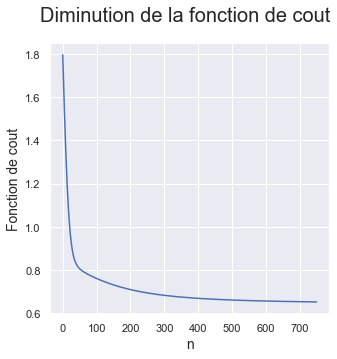

In [27]:
myplot(cost_history2)

### D'apres le modèle développé ci dessus, le patient est à risque. La marge d'erreur est assez haute puisque dans 25 à 30% des cas la véracité des resultats n'est pas justifiée.